```
AUTHOR: JOSH MALARKEY (STINE)
DATE CREATED: 3/18/2023
```

In [1]:
from collections import defaultdict
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import numpy as np
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
import statsmodels.api as sm
from tabulate import tabulate

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# custom modules
import helper_functions

<h1 style='text-align:center'>Wine Quality Dataset:</h1>
<h1 style='text-align:center'>From EDA to Regression Modelling and Validation</h1>


## Table of Contents

- [Abstract/Executive Summary](#abstract)
- [About the Data](#about)
    - [Exploratory Data Analysis](#eda)
- [Methods](#methods)
    - [Regression Types and Assumptions](#assumptions)
    - [Model Specification](#model-spec)
    - [Parameter Estimation](#param-est)
    - [Model Adequacy Checking](#adequacy)
- [Results](#results)
    - [Model Validation](#validation)
    - [Model Use](#use)
- [Conclusion](#conclusion)
- [Citations](#citations)

<span id='abstract'></span>

## Abstract/Executive Summary

The fundamental process of model building using regression is an iterative process, which is eloquently depicted in Figure 1.8 of the Introduction to Linear Regression Analysis, 5th ed textbook [1] shown below. The purpose of this report is to demonstrate a practical example of the iterative model building process using real world data.

<center><img src="figure1_8_stats_theory.png" alt="figure18" width="700"/></center>

The dataset used for this paper’s model building process was originally created for a similar research purpose; to assess the quality of Portuguese wines based on their chemical makeup. The paper published by Cortez et al. [2] assessed data mining and algorithmic approaches to creating a predictive model using advanced regression techniques like support vector machines (SVM) and neural networks. Though these advanced techniques can provide efficient solutions and promising results, simpler linear methods such as logistic and ridge regression are easier to interpret and are sometimes more effective. This paper focuses on several approaches of feature selection and model validation to create the best linear model for classifying wines as good quality or bad quality based the wines physiochemical traits.

The response variable used in the model is based on the numeric quality field within the dataset. For this research paper, wines with quality≥6 are considered good quality and wines below 6 are considered bad quality. After creating several different regression models using various model selection and feature reduction techniques, the best performing was Reduced Model 1 (a.k.a. – the Final Model) which was created using logistic regression with 9 non-transformed independent variables: fixed_acidity,  alcohol, sulphates, volatile_acidity, citric_acid,  free_sulfur_dioxide,  total_sulfur_dioxide, chlorides, and residual_sugar. This Final Model resulted in an average Training Accuracy Score of 75% and an average Validation Accuracy Score of 74%. Ultimately the difference between the Full Model using all 11 variables and the Final Model using 9 variables was not statistically significant. However, the reduced Final Model had no significant issues with multicollinearity whereas the Full Model had 2 variables with severe multicollinearity issues.

<span id='about'></span>
## About the Data

The reason I chose this dataset is because I recently started working in the wine industry with a focus on data analytics/business intelligence and thought it would be interesting to learn something applicable to my work. The original response variable in the dataset was `quality`, which is a score that can considered a categorical variable because the values have a small range of 3-8. This score was used to define the final binary response variable, `good_quality`. In the **Exploratory Data Analysis** section, a formal definition of `good_quality` is created.

<div style="background: #e3c8cd; margin:20px; padding: 20px;">
    <strong>CONTEXT</strong>
    <p>The wines used to create the dataset are 1599 different red and white varietals of the Portuguese Vihno Verde wine style. For privacy reasons, the dataset only contains attributes related to the chemical makeup of each wine, thus other attributes like grapes, brands, prices, etc. are excluded. The dataset is hosted on the UCI Machine Learning Repository website [2].<a href="https://archive.ics.uci.edu/ml/datasets/wine+quality" target="_blank" style='color: darkblue'> https://archive.ics.uci.edu/ml/datasets/wine+quality</a></p>
    
</div>


In [2]:
wine_data = pd.read_csv('winequality-red.csv')
wine_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


After loading the data in, the 11 independent variables displayed below are `fixed_acidity`, `volatile_acidity`, `citric_acid`, `residual_sugar`, `chlorides`, `free_sulfur_dioxide`, `total_sulfur_dioxide`, `density`, `pH`, `sulphates`, and `alcohol`. There are no null values, so no data cleansing was needed before beginning the model building process.

In [3]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


<span id='eda'></span>

## Exploratory Data Analysis

Before beginning the model building process, it helps to plot distributions of each independent variable with the response variable to observe any potential influences, interactions, or other interesting behavior within the data. First the `pandas.describe()` function is used to show the basic statistics for each of the independent variables.

In [4]:
target_variable = 'quality'
features = [col for col in wine_data.columns if col != target_variable]
wine_data[features].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


Overall it looks like variables have a variety of distributions and ranges. For instance, the difference between the mean and median values can give an indication of skew and the IQR, range, and standard deviation can give an idea of how the tails of the distributions will look.

### `quality` target variable

The quality of the wine is the target variable for this dataset. Though it appears to be a numeric field, the values are not continuous, so either Linear or Logistic Regression could work depending on the desired result.

Since the described use case for the dataset is that it <em>"can be to used to build a statistical or machine learning model to determine what makes a 'good' quality wine"</em>, a definition of "good" is needed in order to create a model. Below are the distributions of the `quality` of wines within the dataset to get a better understanding.

In [5]:
helper_functions.descriptive_categorical(dataframe=wine_data, col_name=target_variable, cmap='Blues', alpha_sort=True)

quality,% observations,Cumulative %
3,0.63%,0.63%
4,3.31%,3.94%
5,42.59%,46.53%
6,39.90%,86.43%
7,12.45%,98.87%
8,1.13%,100.00%


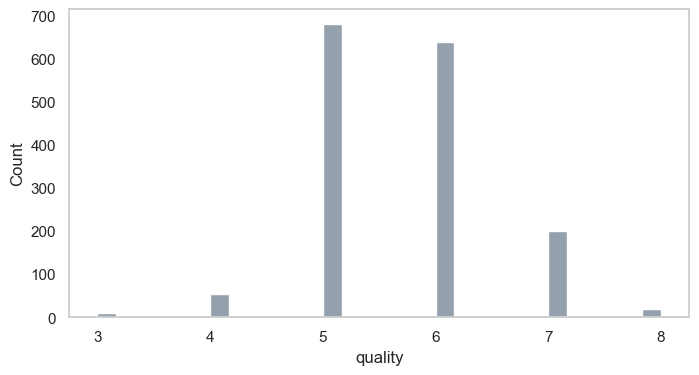

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=wine_data, x='quality', stat='count', color='slategray')
ax.grid(False)
plt.show()

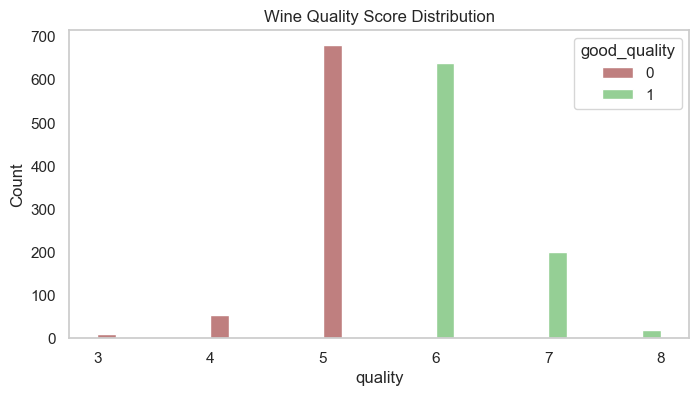

In [7]:
wine_data['good_quality'] = np.where(wine_data['quality'] >= 6, 1, 0)
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=wine_data, x='quality', hue='good_quality', stat='count', palette=['maroon', '#2ca02c'])
ax.set_title('Wine Quality Score Distribution')
ax.grid(False)
plt.show()

In [8]:
helper_functions.descriptive_categorical(dataframe=wine_data, col_name='good_quality', cmap='PiYG', alpha_sort=True)

good_quality,% observations,Cumulative %
0,46.53%,46.53%
1,53.47%,100.00%


Wines with `quality` ≥ 6 are considered 'good wine' (`good_quality` = 1) and wines with `quality` < 6 are considered 'bad wine' (`good_quality` = 0). After defining the binary classification, 744 of the 1599 observations (46.53%) are considered bad quality wines and the remaining 855 (53.47%) are considered good quality wines.

Before beginning the model building process, it helps to plot distributions of each independent variable with the response variable to observe any potential influences on the response variable.

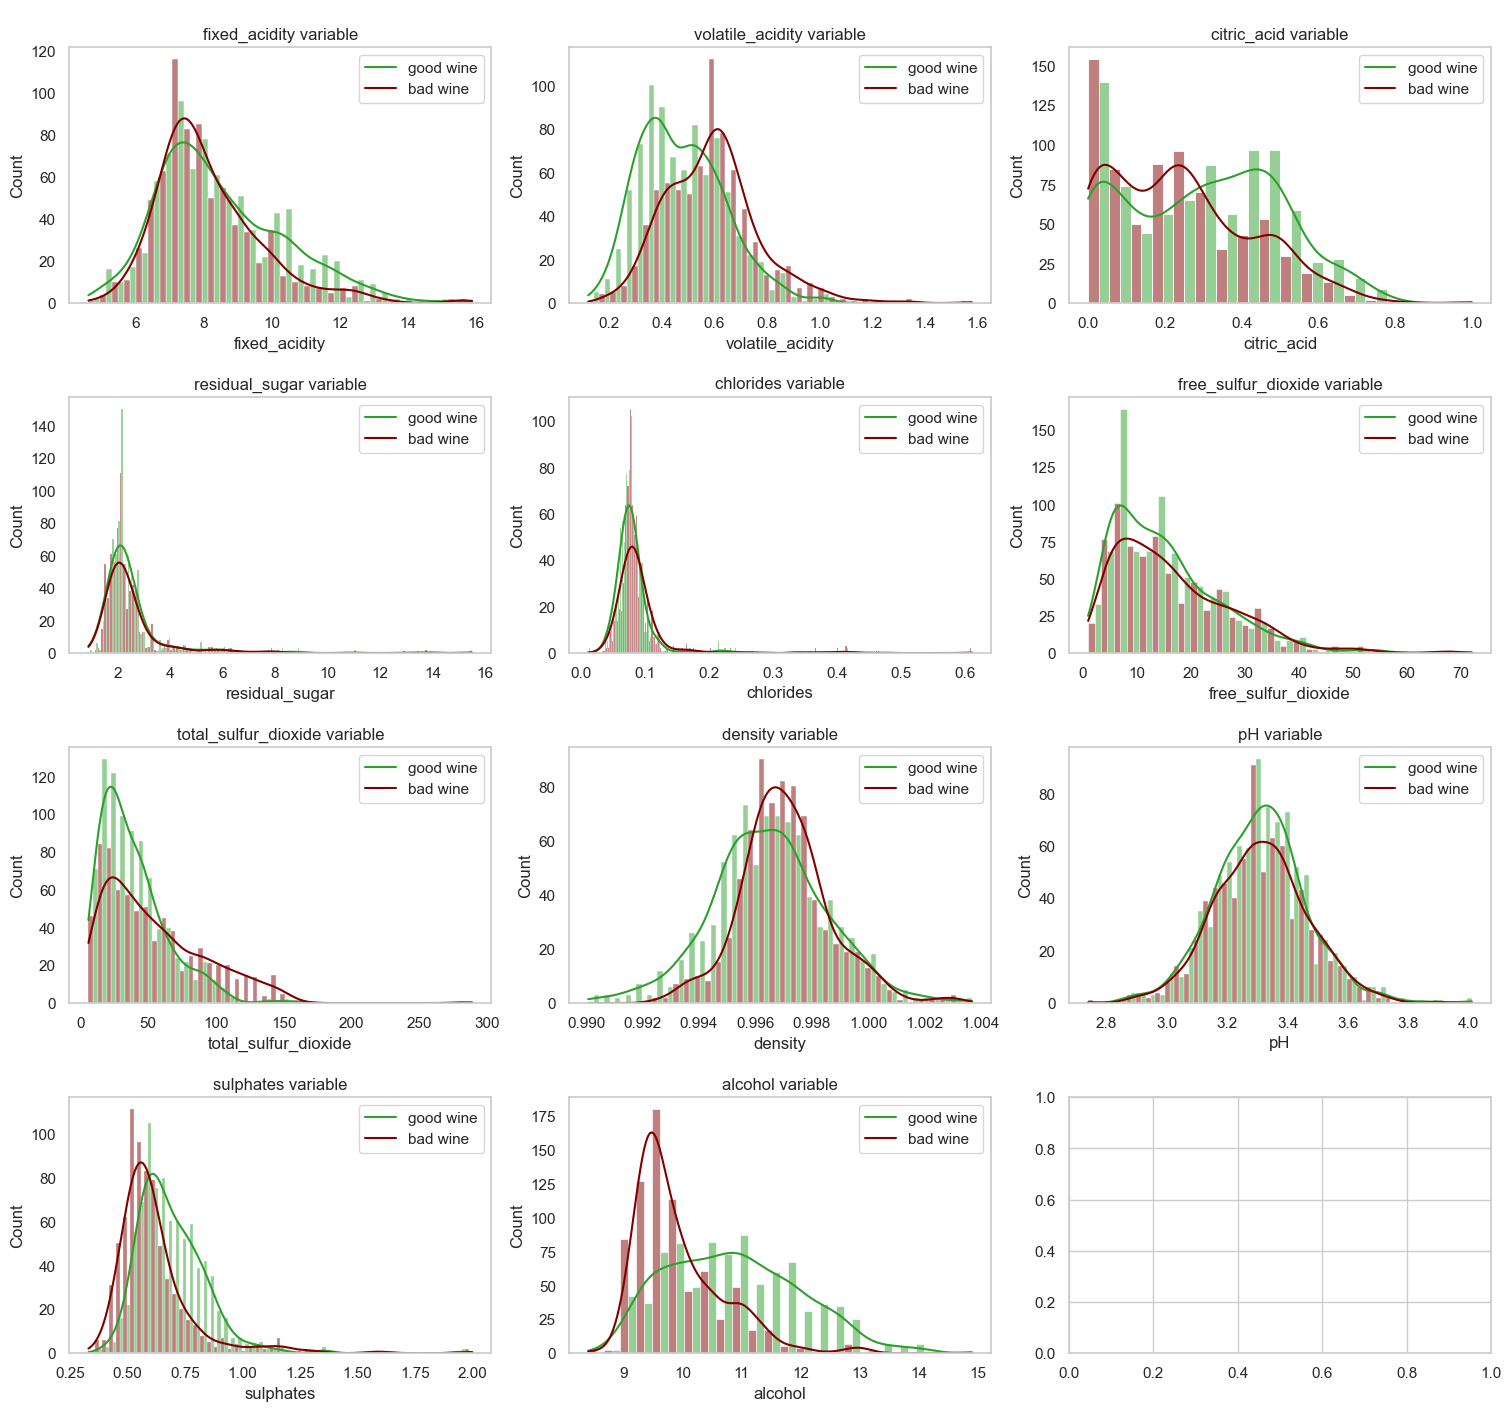

In [9]:
helper_functions.categorical_vs_numeric_mult_histogram(wine_data, 'good_quality', 
                                      features, ['good wine', 'bad wine']
                                      , palette=None, kde=True)

One way to distinguish differentiation between the wine groups is to look at the distributions of good wine vs. bad wine wines from the plots of the response variable with each independent. For example, the histogram/density plots of `volatile_acidity`, `citric_acid`, `total_sulfur_dioxide`, `sulphates`, and `alcohol` show a noticable difference in the distribution shapes of 'good quality' and 'bad quality' wines.

The other independent variables `fixed_acidity`, `residual_sugar`, `chlorides`, `free_sulfur_dioxide`, `density`, and `pH` have similar shaped distribution curves for both good wine and bad wine observations. Thus, the lack of difference in distribution shapes between groups did not indicate a significant relationship between these independent variables and the response variable.

<span id='methods'></span>
## Methods

In the planning stages of modeling, it helps to build a Causal Loop Diagram (CLD) to depict the expected/predicted relationship each independent variable will have on the response variable. After plotting the distributions of independent variable with the response variable, the CLD below was using Visual Paradigm Online (a graphical tool for creating diagrams). The arrows represent the initial hypothesis of correlation between each independent/response variable combination; a '-' represents a negative correlation/regression coefficient and a '+' represents a positive correlation/regression coefficient.


<img src="CLD.png" alt="CLD" width="800"/>

Since the binary response variable is used to categorize wines as either good quality or bad quality it makes sense to use a classification type regression model for this analysis. In general, logistic regression is the simplest classification type model to use because it implements the same concepts as ordinary least squares (OLS) linear regression. Other classification models that can be used are the ridge classifier, K-nearest neighbor (KNN), naive bayes, decision trees, SVM, random forest, and many more.


The methods of this research focused on building logistic regression and ridge classification model types. To create a proper classification model, it’s imperative to ensure it adheres to some basic assumptions. These assumptions were validated during the Model Adequacy Check phase of the model building process in Figure 1.8. Below are six assumptions of logistic regression as referenced in the Statology article [3]. The ridge classifier model also makes the same assumptions as the logistic regression model [4].

### Regression Types and Assumptions

Since the binary response variable is used to categorize wines as either good quality or bad quality it makes sense to use a classification type regression model for this analysis. In general, logistic regression is the simplest classification type model to use because it implements the same concepts as ordinary least squares (OLS) linear regression. Other classification models that can be used are the ridge classifier, K-nearest neighbor (KNN), naive bayes, decision trees, SVM, random forest, and many more.

The methods of this research focused on building logistic regression and ridge classification model types. To create a proper classification model, it’s imperative to ensure it adheres to some basic assumptions. These assumptions were validated during the Model Adequacy Check phase of the model building process in Figure 1.8. Below are six assumptions of logistic regression as referenced in the Statology article [3]. The ridge classifier model also makes the same assumptions as the logistic regression model [4].

<center><img src="figure1_8_model_building.png" alt="ev_CLD" width="600"/></center>

#### Logistic Regression Assumptions:
1. [X] The Response Variable is binary
    - `good_quality` will be the binary response variable.
2. [X] The observations are independent
    - The given dataset is clean, so observations are assumed to be independent.
3. [X] The sample size is sufficiently large
    -  The sample size is 1599, which is sufficient.
4. [ ] There are no extreme outliers
5. [ ] There is a linear relationship between the explanatory and logit of the response variable
6. [ ] No multicollinearity among explanatory variables

<br>

Assumption 4 is checked during the Model Adequacy Check phase for each model where any outliers or influential observations are detected. Assumption 5 is also  checked during the Model Adequacy Check where each independent variable is plotted with the log odds. Finally, Assumption 6 is checked during the Model Adequacy Check phase where multicollinearity is evaluated by calculating the variance inflation factor (VIF).

## Building the Full Model:


### Model Specification

Now that the `Data` and `Theory` portions of the Regression model-building process have been covered, the next steps covered are the `Model Specification`, `Parameter Estimation`, and `Model Adequacy Checking` portions highlighted in the blue rectangle above. To begin, the Full Model was fitted to the entire dataset, which contains all 11 continuous variables and the response variable. Then, a statistical summary was produced to assess the adequacy and determine the baseline performance. After creating and assessing the Full Model, several methods were used for feature selection to create several Reduced Models which were assessed and validated against the performance of the Full Model. Lastly, a Final Model with the best overall performance was selected for the final `Model Use` stage.

In [10]:
model_data = pd.DataFrame(wine_data)
model_data.drop(labels='quality', axis=1, inplace=True)
model_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,good_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### Parameter Estimation of Full Model 

First a Logistic Regression model is fitted with all variables using the `statsmodels.api` package. The regression model summary outputs estimates of the model parameters with 95% confidence intervals. Before trying any automated feature selection approaches like forward/backward selection, it can be sufficient to assess significance of a variable based on its coefficient value confidence interval (CI). If the CI contains 0 then there's a good possibility the variable can be removed for better model performance.

In [11]:
target_variable = 'good_quality'
full_model_data = pd.DataFrame(model_data)
full_model_features = full_model_data.loc[:, full_model_data.columns != target_variable].columns
X = sm.add_constant(full_model_data[full_model_features])
y = full_model_data[target_variable]
full_model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(full_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -827.81
Date:                Sun, 14 May 2023   Deviance:                       1655.6
Time:                        11:36:23   Pearson chi2:                 1.87e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2925
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   42.9499 

### Full Model Adequacy Check - Validate Remaining Assumptions

4. [X] There are no extreme outliers

One way to determine outliers or influential observations in a dataset is to use the Cook's Distance and the Standardized Pearson's Residuals. As a rule of thumb, a Cook's distance threshold is 4 / n, and a Standardized Residual Threshold of 3 were used to detect outlier/extreme observations.

In [12]:
distances = helper_functions.get_outliers(full_model)
outliers = pd.DataFrame(distances[distances['outlier']=='outlier'])
outliers.sort_values('cooks_d', ascending=False, inplace=True)
print('Outliers in Dataset: ', outliers.shape[0])

Outliers in Dataset:  5


In [13]:
outliers.head()

,cooks_d,cooks_threshold,std_residual,std_threshold,outlier
652,0.027095,0.002502,16.671395,3,outlier
1429,0.004741,0.002502,4.137892,3,outlier
234,0.004482,0.002502,3.400554,3,outlier
239,0.004482,0.002502,3.400554,3,outlier
1441,0.003580,0.002502,3.020696,3,outlier


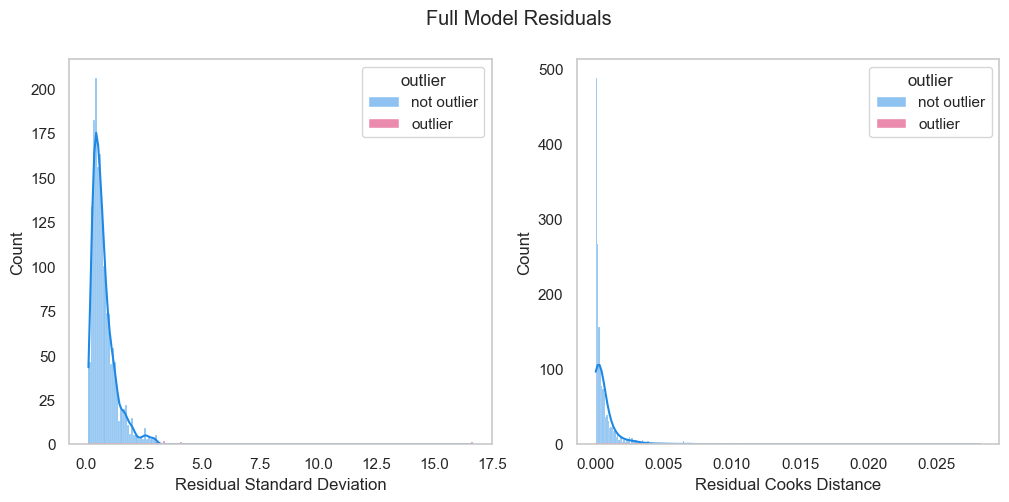

In [14]:
helper_functions.plot_residuals(full_model, 'Full Model Residuals')

Based on these thresholds, there were 5 observations deemed to be outliers as shown in the plots above. To determine if the outliers are truly influential or creating bias within the model, they should be removed from the dataset, then refit the model on the new reduced dataset. The beta coefficient values for the model trained, without outliers, can be compared with the model trained on the full dataset, including the outliers.

If the beta coefficients between both models, trained with and without outliers are not significantly different then the outlier observations should remain in the Final Model. Removing outliers that do not create biases from a training dataset can create another set of biases within the model. Therefore, it is important to keep the outliers in the training dataset. 

In [15]:
data_no_outliers = pd.DataFrame(model_data)
data_no_outliers.drop(labels=outliers.index, axis=0, inplace=True)
data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1594 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1594 non-null   float64
 1   volatile_acidity      1594 non-null   float64
 2   citric_acid           1594 non-null   float64
 3   residual_sugar        1594 non-null   float64
 4   chlorides             1594 non-null   float64
 5   free_sulfur_dioxide   1594 non-null   float64
 6   total_sulfur_dioxide  1594 non-null   float64
 7   density               1594 non-null   float64
 8   pH                    1594 non-null   float64
 9   sulphates             1594 non-null   float64
 10  alcohol               1594 non-null   float64
 11  good_quality          1594 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 161.9 KB


In [16]:
target_variable = 'good_quality'
full_model_features = data_no_outliers.loc[:, data_no_outliers.columns != target_variable].columns
X = sm.add_constant(data_no_outliers[full_model_features])
y = data_no_outliers[target_variable]
full_model_no_outliers = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(full_model_no_outliers.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1594
Model:                            GLM   Df Residuals:                     1582
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -810.65
Date:                Sun, 14 May 2023   Deviance:                       1621.3
Time:                        11:36:24   Pearson chi2:                 1.54e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3054
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   40.7950 

After fitting the Final Model both with and without outliers in the training set, the beta coefficients did not significantly change. Thus, the outliers were not of concern and were left in the training dataset, validating this assumption.

5. [X] There is a linear relationship between the explanatory and logit of the response variable

Based on the plots below, the independent variables have a strong linear relationship with the log-odds values/logit function, validating this assumption.

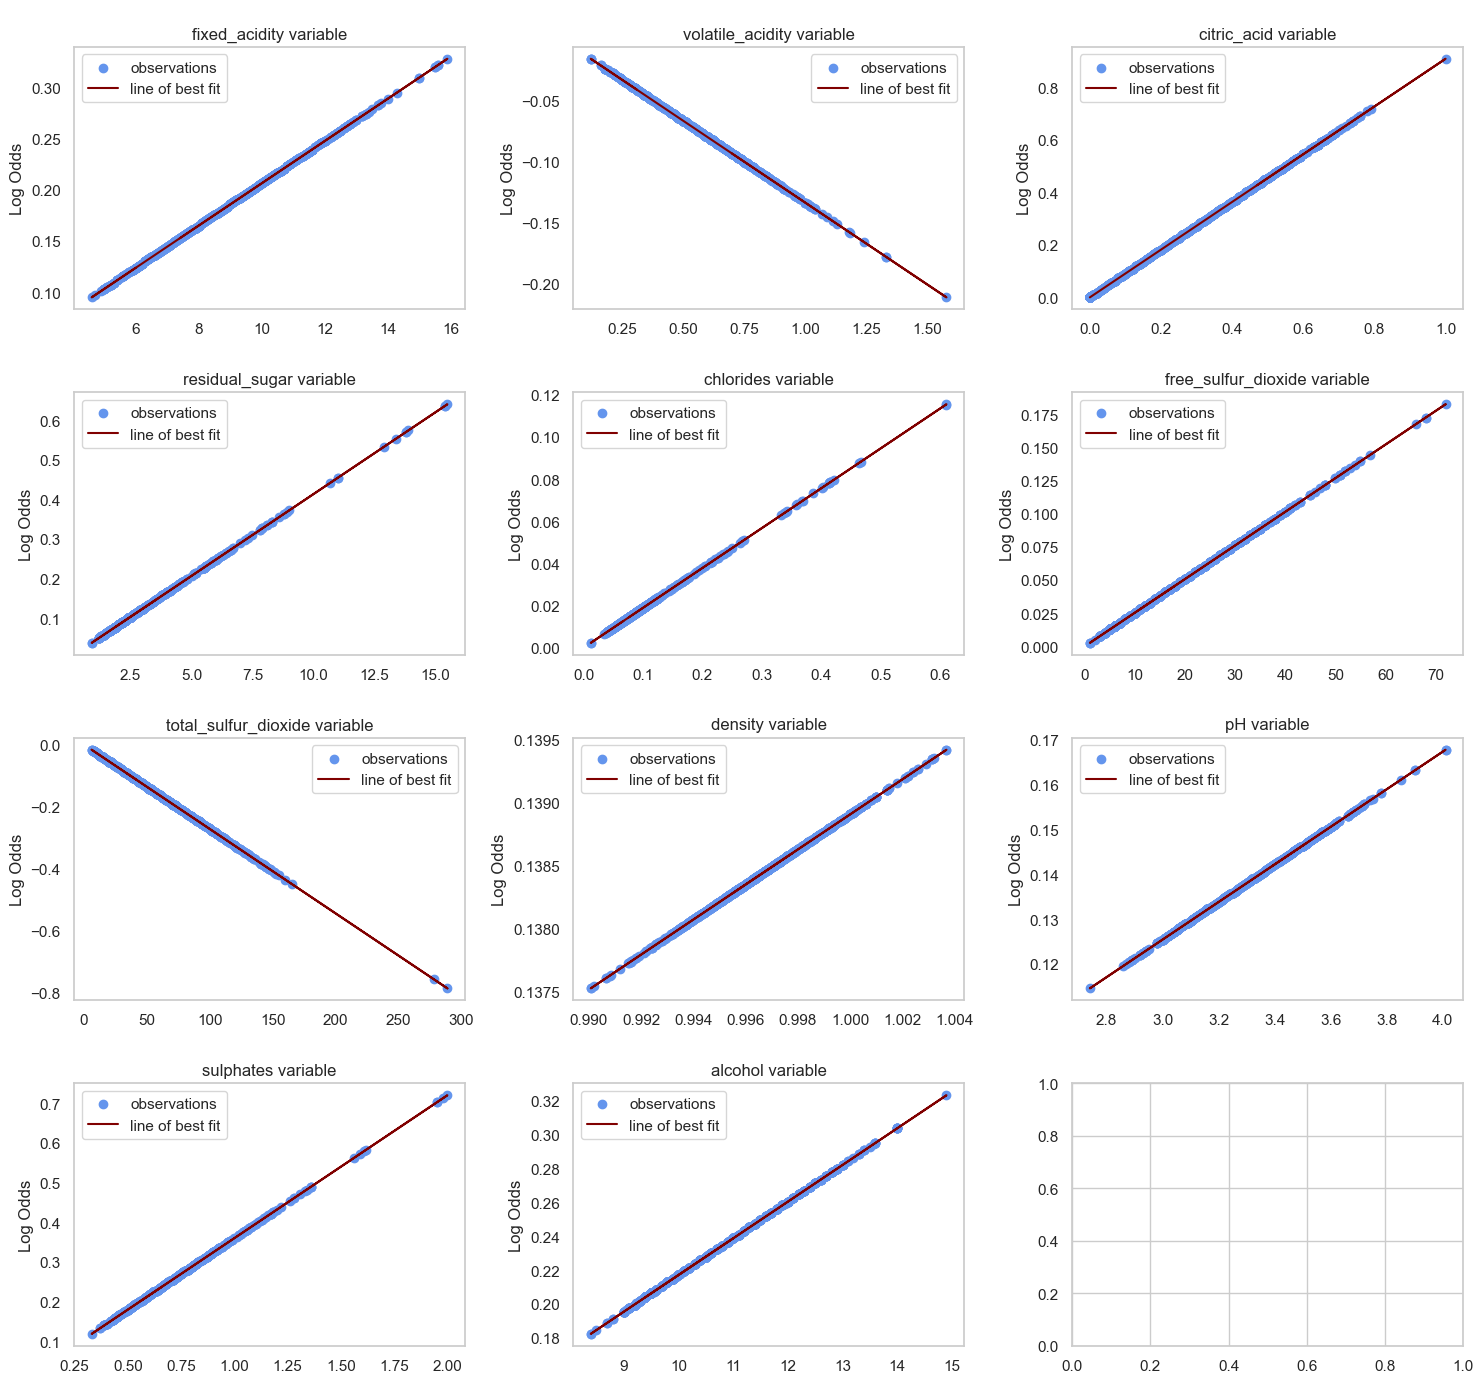

In [17]:
helper_functions.plot_log_odds_vs_numeric(model_data, 'good_quality', full_model_features)

6. [X] No multicollinearity among explanatory variables
    - The VIF values >=1,000 for `density` and `pH` are cause for concern here. As a rule of thumb, a VIF > 10 indicate a poor estimation because of multicollinearity. Though in general, "if the condition number is less than 100, there is no serious problem with multicollinearity. Condition numbers between 100 and 1000 imply moderate to strong multicollinearity, and if it exceeds 1000, severe multicollinearity is indicated." [1]

However, as features are removed, the VIF will need to be recalculated. A balance must be struck between removing variables to decrease multicollinearity and keeping variables to maintain a feasible model.

In [18]:
full_model_vif = helper_functions.get_model_vif(full_model_data[full_model_features])
full_model_vif.head(12)

,feature,VIF
7,density,1479.287209
8,pH,1070.967685
10,alcohol,124.394866
0,fixed_acidity,74.452265
9,sulphates,21.590621
1,volatile_acidity,17.060026
2,citric_acid,9.183495
4,chlorides,6.554877
6,total_sulfur_dioxide,6.519699
5,free_sulfur_dioxide,6.442682


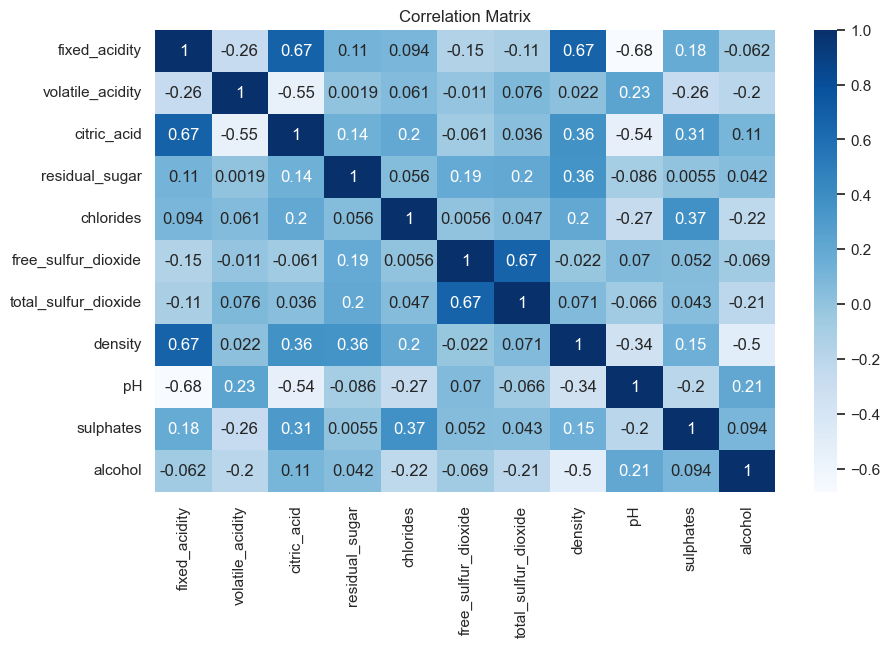

In [19]:
helper_functions.plot_correlation(full_model_data[full_model_features])

### Full Model Adequacy Check - Model Performance
The Psuedo R-sq is only 0.2925 for this model which is not a great fit. Additionally, the deviance of the model is 1655.6 which indicates that there is some inaccuracies with the model.

In [20]:
print(full_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -827.81
Date:                Sun, 14 May 2023   Deviance:                       1655.6
Time:                        11:36:28   Pearson chi2:                 1.87e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2925
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   42.9499 

### Full Model Validation

After fitting and assessing the Final Model for adequacy, the next step is to validate the model by evaluating the predictive ability of it. This involves splitting the data into a training and testing set where the model is trained using one portion of the sample data and then tested using another.

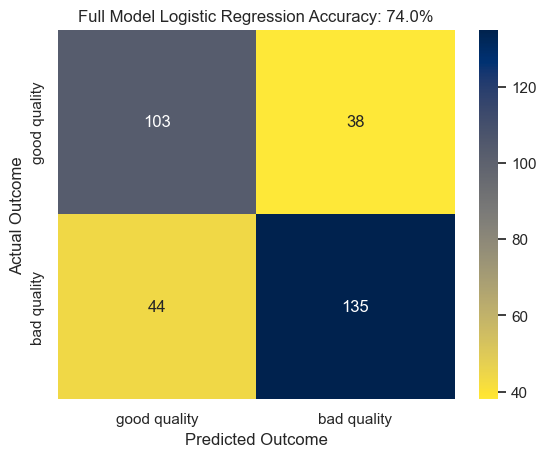

In [21]:
X = full_model_data[full_model_features]
y = full_model_data[target_variable]
model_name = 'Full Model Logistic Regression'
helper_functions.plot_confusion_matrix(X, y, ['good quality', 'bad quality'], model_name, 
                                       algo=linear_model.LogisticRegression(), test_size=0.2, cmap=None)

One way to perform model validation is using K-Fold cross validation, usually with K = 5, to look at more than just one test/training split. Doing a K-Fold cross validation helps reduce overfitting of the model since it is trained/tested on the entire dataset across an even subsample, K times. Below is a plot of the Full Model accuracy across the 5 folds.

Mean Training Accuracy score:  74.58
Mean Validation Accuracy score:  72.8


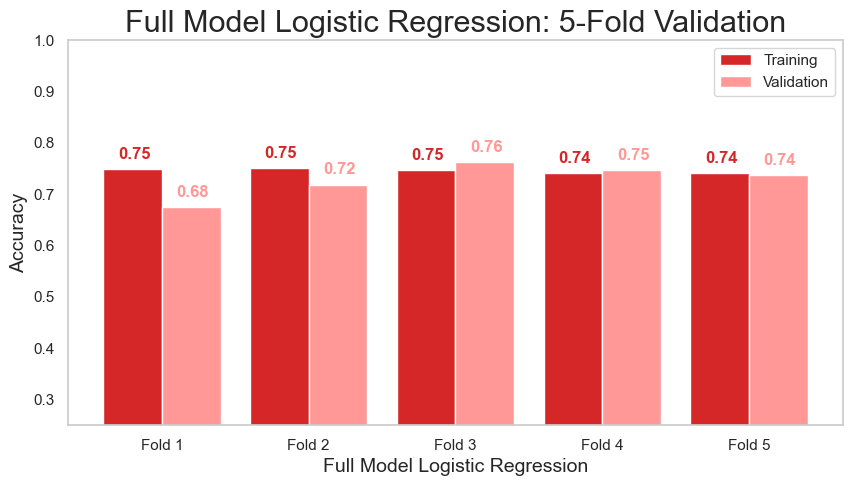

In [22]:
results_df = pd.DataFrame(columns=['Model Name', 'Model Type', 'Mean Training Accuracy', 'Mean Validation Accuracy'])

helper_functions.plot_k_fold_validation(linear_model.LogisticRegression(fit_intercept=True), results_df, 'Full Model', 
                       'Logistic Regression', full_model_data[full_model_features], full_model_data[target_variable], 
                       palette=['#d62728', '#ff9896'], folds=5)

The Full Model created with logistic regression (i.e., the baseline) performed fairly well with a mean training accuracy score of 75% and a mean validation accuracy of 73%. As shown in the plots below, the training/validation for Fold 1 showed a noticeable gap between both scores. One possible reason for this is the training data was overfitted due to the high multicollinearity of both pH and density.

## Building a Reduced Model using Correlation

In [23]:
full_model_vif

,feature,VIF
7,density,1479.287209
8,pH,1070.967685
10,alcohol,124.394866
0,fixed_acidity,74.452265
9,sulphates,21.590621
1,volatile_acidity,17.060026
2,citric_acid,9.183495
4,chlorides,6.554877
6,total_sulfur_dioxide,6.519699
5,free_sulfur_dioxide,6.442682


### Reduced Model 1 Specification

As seen above, `density` and `pH` have severe issues of multicollinearity. Thus, they can be removed and then recalculate VIF for all remaining variables.

In [24]:
reduced_model_features = list(full_model_features)
reduced_model_features.remove('density')
reduced_model_features.remove('pH')
reduced_model_vif = helper_functions.get_model_vif(full_model_data[reduced_model_features])
reduced_model_vif.head(10)

,feature,VIF
0,fixed_acidity,37.557809
8,alcohol,37.137148
7,sulphates,21.218142
1,volatile_acidity,15.651760
2,citric_acid,8.636667
5,free_sulfur_dioxide,6.357695
6,total_sulfur_dioxide,5.987189
4,chlorides,5.935002
3,residual_sugar,4.660704


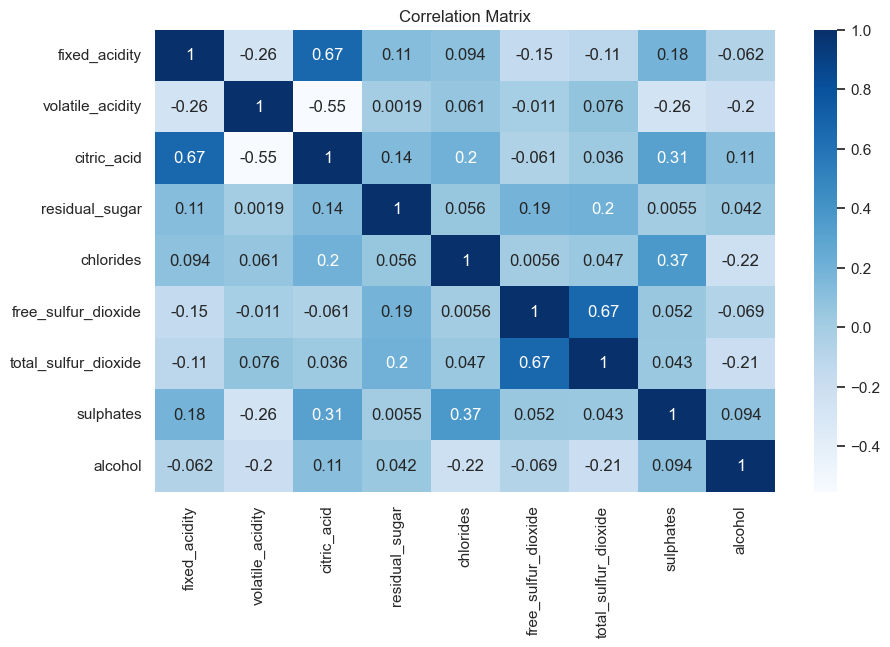

In [25]:
helper_functions.plot_correlation(full_model_data[reduced_model_features])

6. [X] No multicollinearity among explanatory variables
    - The VIF values >=100 for `density` and `pH` are cause for concern here. We will keep these variables for now since they are in the full model, but we need to consider this when building a reduced model, but it's good to know that a model with all features has some potential for being biased.

### Reduced Model 1: Parameter Estimation and Model Adequacy Check

As we can see below, the Psuedo R-sq is only 0.2918 for this model which is essentially the same as the Full Model and Reduced Model 1. Additionally, we can see that the deviance of the model is 1657.2 which is also slightly worse than the Full Model and Reduce Model 1, but not by much at all. Overall, it's still not a great fit, but at least we know that multicollinearity is not too concerning for this model as well.

In [26]:
target_variable = 'good_quality'
model_1_data = pd.DataFrame(model_data)
model_1_features = list(reduced_model_features)
X = sm.add_constant(model_1_data[model_1_features])
y = model_1_data[target_variable]
model_1 = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1589
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -828.60
Date:                Sun, 14 May 2023   Deviance:                       1657.2
Time:                        11:36:29   Pearson chi2:                 1.84e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2918
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -9.2044 

### Reduced Model 1 Validation

Based on the Model Validation, it looks like Reduced Model 1 is the 'best' performing so far in terms of `Mean Training Accuracy score` and `Mean Validation Accuracy score`.

Mean Training Accuracy score:  74.81
Mean Validation Accuracy score:  73.98


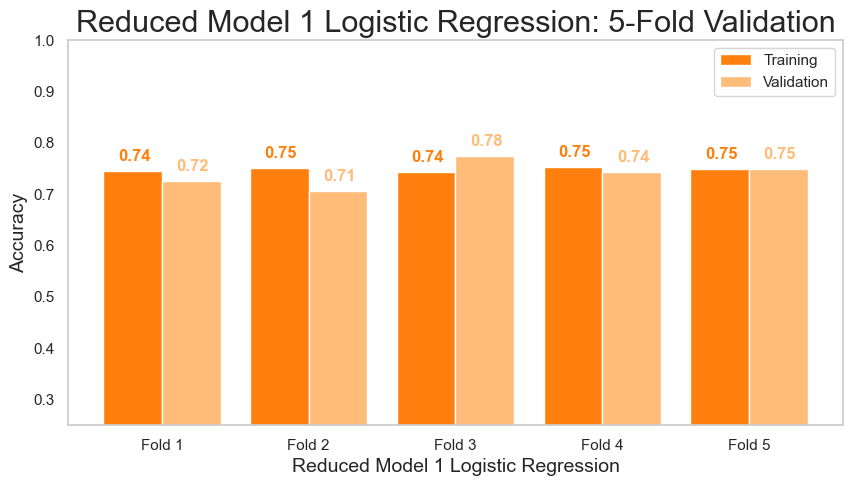

In [27]:
helper_functions.plot_k_fold_validation(linear_model.LogisticRegression(fit_intercept=True), results_df, 'Reduced Model 1', 
                       'Logistic Regression', model_1_data[model_1_features], model_1_data[target_variable], 
                       palette=['#ff7f0e', '#ffbb78'], folds=5)

## Building a Reduced Model Stepwise Feature Selection

### Reduced Model 2: Model Specification

Next, a reduced model can created using the `SequentialFeatureSelector` import from `sklearn.feature_selection` package. This import uses forward and backward feature selection by scoring the features based on accuracy. The python code iterates through the `tols` values as a tolerance for the number of features to select.

In [28]:
tols = [0.1, 0.00001, 0.000000000001, 0.0000000000000000000001, 0.0000000000000000000000000000000000000000001
       ,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000001]
model_2_features = None
for i, tol in enumerate(tols):
    selector = sfs(linear_model.LogisticRegression(fit_intercept=True), n_features_to_select='auto', tol=tol, scoring='accuracy')
    results = selector.fit(X, y)
    if i !=0:
        model_features = selector.get_feature_names_out()
        if model_features.all() != model_2_features.all():
            model_2_features = model_features
    model_2_features = selector.get_feature_names_out()
print('Reduced Features: ', tol, model_2_features)

Reduced Features:  1e-85 ['volatile_acidity' 'citric_acid' 'residual_sugar' 'free_sulfur_dioxide'
 'total_sulfur_dioxide' 'sulphates' 'alcohol']


### Reduced Model 2: Parameter Estimation

After doing the stepwise selection process, we can see the features returned are `volatile_acidity`, `citric_acid`, `residual_sugar`, `density`, `free_sulfur_dioxide`, `total_sulfur_dioxide`, `sulphates`, `alcohol`. This second iteration of a reduced model can be compared against both the full and reduced model 1.

In [29]:
model_2_data = pd.DataFrame(model_data)
target_variable = 'good_quality'
X = sm.add_constant(model_2_data[model_2_features])
y = model_2_data[target_variable]
model_2 = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1591
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -836.00
Date:                Sun, 14 May 2023   Deviance:                       1672.0
Time:                        11:36:40   Pearson chi2:                 1.70e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2852
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -8.3800 

### Reduced Model 2 Adequacy Check - Model Performance
As we can see below, the Psuedo R-sq is only 0.2507 for this model which is only slightly lower than the Full Model and the prior reduced models as they were roughly 0.29. Additionally, we can see that the deviance of the model is 1747.4 which is larger by a fair amount. Overall, it's still not a great fit, but at least we know that multicollinearity is not too concerning for this model as well.

In [30]:
print(model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1591
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -836.00
Date:                Sun, 14 May 2023   Deviance:                       1672.0
Time:                        11:36:40   Pearson chi2:                 1.70e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2852
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -8.3800 

### Reduced Model 2 Validation

Reduced Model 1 is still best overall in terms of Mean Training Accuracy score (74.81) and Mean Validation Accuracy score (73.98).

Mean Training Accuracy score:  74.75
Mean Validation Accuracy score:  73.92


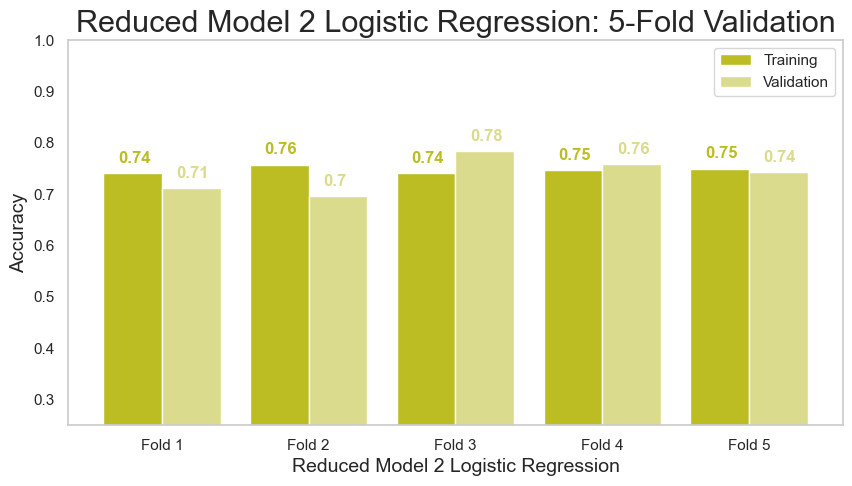

In [31]:
helper_functions.plot_k_fold_validation(linear_model.LogisticRegression(fit_intercept=True), results_df, 'Reduced Model 2', 
                       'Logistic Regression', model_2_data[model_2_features], model_2_data[target_variable], 
                       palette=['#bcbd22', '#dbdb8d'], folds=5)

## Building a Reduced Model using Variable Transformation

Based on the regression summary results, some independent variables do not have significant coefficient values. Therefore one possible way to further improve model performance is to transform these non-significant independent variables then refit the model.

In [32]:
print(full_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -827.81
Date:                Sun, 14 May 2023   Deviance:                       1655.6
Time:                        11:36:41   Pearson chi2:                 1.87e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2925
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   42.9499 

Based on the Full Model summary, `fixed_acidity`, `residual_sugar`, `density`, and `pH` do not have a significant impact on the model. Below are the summary results of all log transformed independent variables.

In [33]:
model_log_data = pd.DataFrame(full_model_data)
for feature in full_model_features:
    model_log_data[f'{feature}:log_{feature}'] = model_log_data[feature].apply(lambda x: x * np.log(x))
model_log_data.fillna(value=0, axis=1, inplace=True)
    
X = sm.add_constant(model_log_data)
for col in X.columns:
    if 'log' not in col or col == target_variable:
        X.drop(labels=col, axis=1, inplace=True)

log_model = sm.GLM(model_log_data[target_variable], X, family=sm.families.Binomial()).fit()
print(log_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1588
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -859.96
Date:                Sun, 14 May 2023   Deviance:                       1719.9
Time:                        11:36:41   Pearson chi2:                 1.73e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2635
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

The `fixed_acidity:log_fixed_acidity` looks like a good replacement for `fixed_acidity`. Similarly, `density:log_density` and `pH:log_pH` look like they might be better regressors than the non-transformed `density` and `pH` regressors. Unfortunately, the p-value for `log_residual_sugar:log_residual_sugar` is much higher than the untransformed `log_residual_sugar` regressor.

In [34]:
model_sq_data = pd.DataFrame(model_data)
for feature in full_model_features:
    model_sq_data[f'{feature}:sq_{feature}'] = model_sq_data[feature].apply(lambda x: x**2)
model_sq_data.fillna(value=0, axis=1, inplace=True)
    
X = sm.add_constant(model_sq_data)
for col in X.columns:
    if 'sq' not in col or col == target_variable:
        X.drop(labels=col, axis=1, inplace=True)

sq_model = sm.GLM(model_sq_data[target_variable], X, family=sm.families.Binomial()).fit()
print(sq_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1588
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -844.48
Date:                Sun, 14 May 2023   Deviance:                       1689.0
Time:                        11:36:41   Pearson chi2:                 2.49e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2776
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

After transforming the variables by taking the square, the new variables `residual_sugar:sq_residual_sugar`, `log_residual_sugar: log_residual_sugar_sq` is much better than the non-transformed version because the p-value is only 0.182 as compared to 0.304. One last method will be to take the reciprocal of each variable to see if the transformed version of `residual_sugar` is any better.

In [35]:
model_reciprocal_data = pd.DataFrame(full_model_data)
for feature in full_model_features:
    model_reciprocal_data[f'{feature}:{feature}_recip'] = np.divide(1,  model_reciprocal_data[feature], where= model_reciprocal_data[feature]!=0)
model_reciprocal_data.fillna(value=0, axis=1, inplace=True)
    
X = sm.add_constant(model_reciprocal_data)
for col in X.columns:
    if 'recip' not in col or col == target_variable:
        X.drop(labels=col, axis=1, inplace=True)

reciprocal_model = sm.GLM(model_reciprocal_data[target_variable], X, family=sm.families.Binomial()).fit()
print(reciprocal_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1588
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -839.95
Date:                Sun, 14 May 2023   Deviance:                       1679.9
Time:                        11:36:41   Pearson chi2:                 1.66e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2817
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Finding the reciprocal didn't yield any better results, so let's try creating a reduced model using the squared transformation of `residual_sugar`.

### Reduced Model 3: Parameter Estimation

After doing the stepwise selection process, we can see the features returned are `volatile_acidity`, `citric_acid`, `residual_sugar`, `free_sulfur_dioxide`, `total_sulfur_dioxide`, `sulphates`, `alcohol`. For the third iteration of the reduced model, `residual_sugar` is replaced with the transformed `residual_sugar:sq_residual_sugar` variable, and `fixed_acidity:log_fixed_acidity` is also added. Finally, the model is trained and summarized below to compare the against the performance of the other two reduced models and the full model.

In [36]:
model_3_data = pd.DataFrame(model_data)

log_columns = model_log_data[['fixed_acidity:log_fixed_acidity']]
sq_columns = model_sq_data['residual_sugar:sq_residual_sugar']
model_3_features = list(model_2_features)
model_3_features.remove('residual_sugar')
X = pd.concat([model_3_data[model_3_features], log_columns, sq_columns], axis=1)
X = sm.add_constant(X)
y = model_3_data[target_variable]
model_3 = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1590
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -831.44
Date:                Sun, 14 May 2023   Deviance:                       1662.9
Time:                        11:36:41   Pearson chi2:                 1.96e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2893
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

### Reduced Model 3 Adequacy Check - Model Performance

As seen above, the Psuedo R-sq is  0.2893 for this model which is slightly better than Reduced Model 2 and slightly worse than the Full Model and Reduced Model 1. Additionally, we can see that the deviance of the model is 1731.8 which is larger than the deviance of the full model by a fair amount (~200). Overall, this model looks pretty fined tuned.

### Reduced Model 3 Validation

Similar to Reduced Model 2, this third iteration of a Reduced Model still doesn't beat Reduced Model 1 in terms of Mean Training Accuracy score (74.81) and Mean Validation Accuracy score (73.98).

Mean Training Accuracy score:  74.72
Mean Validation Accuracy score:  73.67


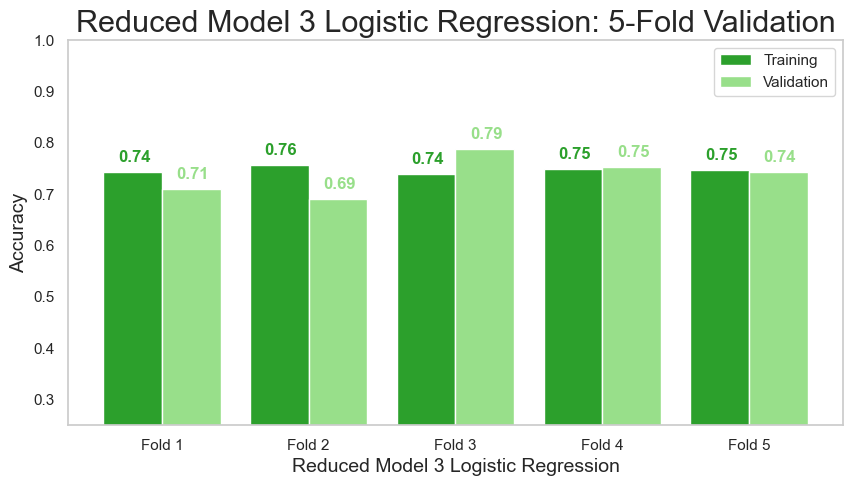

In [37]:
helper_functions.plot_k_fold_validation(linear_model.LogisticRegression(fit_intercept=True), results_df, 'Reduced Model 3', 
                       'Logistic Regression', model_3_data[model_3_features], model_3_data[target_variable], 
                       palette=['#2ca02c', '#98df8a'], folds=5)

Mean Training Accuracy score:  74.75
Mean Validation Accuracy score:  73.92


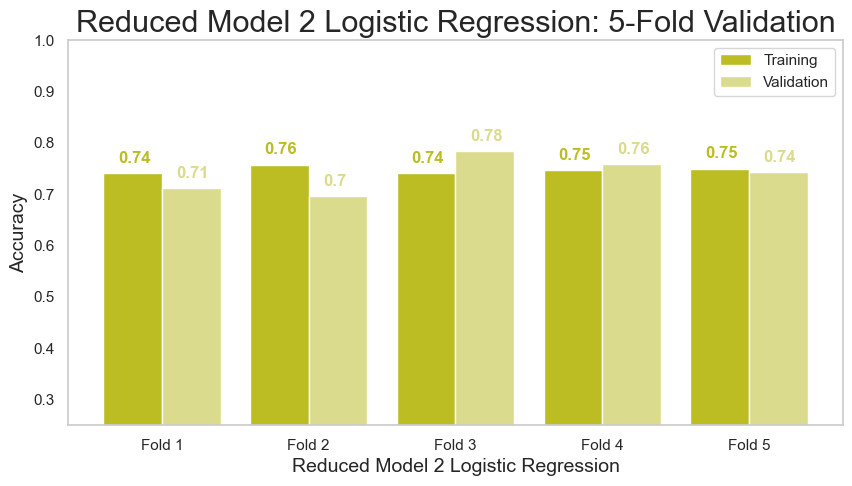

In [38]:
helper_functions.plot_k_fold_validation(linear_model.LogisticRegression(fit_intercept=True), results_df, 'Reduced Model 2', 
                       'Logistic Regression', model_2_data[model_2_features], model_2_data[target_variable], 
                       palette=['#bcbd22', '#dbdb8d'], folds=5)

Mean Training Accuracy score:  74.81
Mean Validation Accuracy score:  73.98


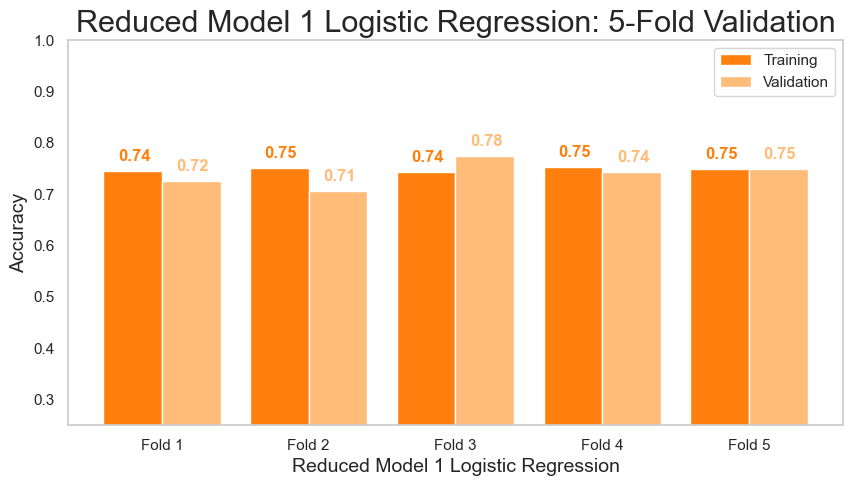

In [39]:
helper_functions.plot_k_fold_validation(linear_model.LogisticRegression(fit_intercept=True), results_df, 'Reduced Model 1', 
                       'Logistic Regression', model_1_data[model_1_features], model_1_data[target_variable], 
                       palette=['#ff7f0e', '#ffbb78'], folds=5)

After going through the iterative model building process highlighted below in blue four separate times, the "Final Model" that will move onto the final stage of `Model Use` is Reduced Model 1 because it had the highest Mean Training Accuracy score of  74.81 and highest Mean Validation Accuracy score:  73.98. It's also worth noting that all 3 reduced models outperformed the Full Model that had a Mean Training Accuracy score of 74.58 and a Mean Validation Accuracy score of 72.8.


<center><img src="figure1_8_model_building.png" alt="ev_CLD" width="600"/></center>

**Final Model Formula:**
`good_quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + sulphates + alcohol`

In [40]:
print(model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           good_quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1589
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -828.60
Date:                Sun, 14 May 2023   Deviance:                       1657.2
Time:                        11:36:42   Pearson chi2:                 1.84e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2918
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -9.2044 

### ANOVA: Full vs. Final Model

During the `Model Adequacy Checking` phase when building the Full Model, it was noted that there were severe issues of multicollinearity with `density` and `pH` whereas the Final Model does not have this issue. It's also clear that the Final Model outperforms the Full Model in mean test and training accuracy scores. However, it's unclear if the differences between the two models are statistically significant.

In order to test this, it's possible to use the `rpy2.robjects` package to take advantage of the `anova` functionality of the R programming language in a Python Jupyter Notebook.

In [41]:
utils = importr('utils')
stats = importr('stats')
model_data.to_csv('r_modelling_wine_data.csv', index=False)

r_data = utils.read_csv('r_modelling_wine_data.csv')
full_model_formula = 'good_quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol'
r_full_model = stats.glm(formula=ro.r(full_model_formula), data=r_data,family=ro.r('binomial(link="logit")'))

final_model_formula = 'good_quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar  + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + sulphates + alcohol'
r_final_model = ro.r.glm(formula=ro.r(final_model_formula), data=r_data,family=ro.r('binomial(link="logit")'))

anova = ro.r.anova(r_final_model, r_full_model, test='Chisq')
print(anova)

Analysis of Deviance Table

Model 1: good_quality ~ fixed_acidity + volatile_acidity + citric_acid + 
    residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + 
    sulphates + alcohol
Model 2: good_quality ~ fixed_acidity + volatile_acidity + citric_acid + 
    residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + 
    density + pH + sulphates + alcohol
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1      1589     1657.2                     
2      1587     1655.6  2   1.5673   0.4567



Based on the ANOVA table, the difference between the Full Model and Final Model is not significant. However, it would be wise to use the Final Model as it does not violate any assumptions of logistic regression and has better predictive performance.

### Other Classification Models using Final Model features

Mean Training Accuracy score:  74.69
Mean Validation Accuracy score:  73.73


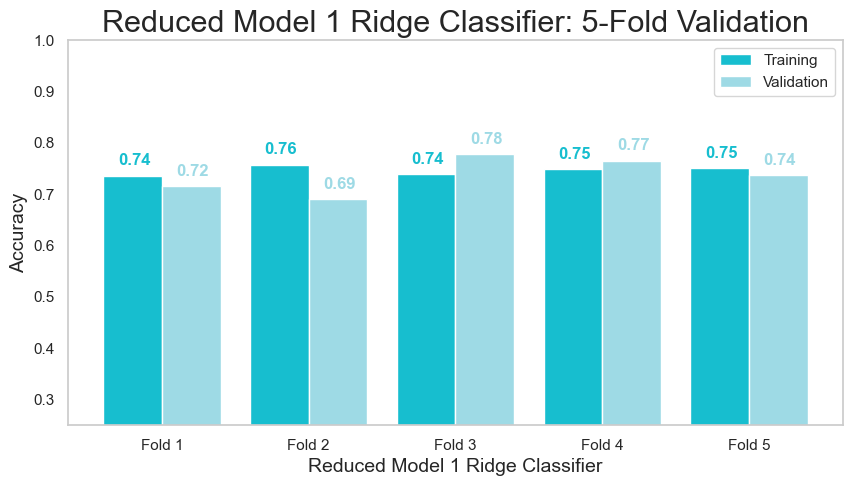

In [42]:
helper_functions.plot_k_fold_validation(linear_model.RidgeClassifierCV(fit_intercept=True), results_df, 'Reduced Model 1', 
                       'Ridge Classifier', model_1_data[model_1_features], model_1_data[target_variable], 
                       palette=['#17becf', '#9edae5'], folds=5)

Mean Training Accuracy score:  69.08
Mean Validation Accuracy score:  66.16


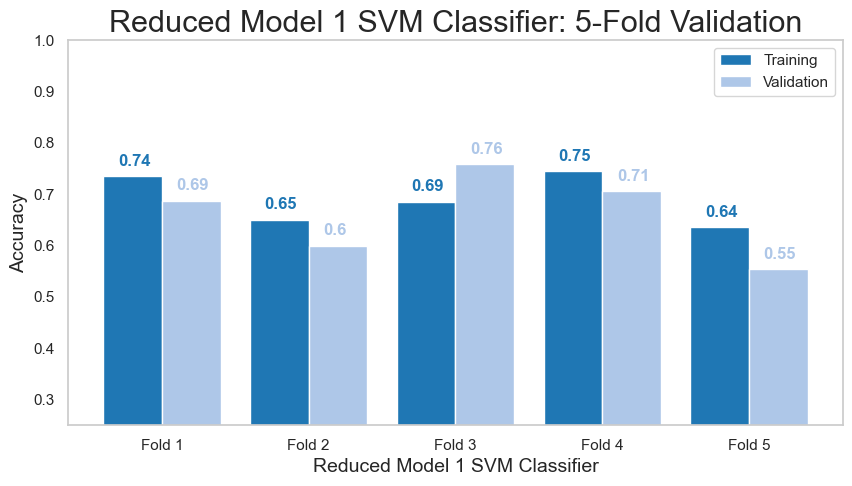

In [43]:
helper_functions.plot_k_fold_validation(svm.LinearSVC(fit_intercept=True, random_state=24), results_df, 'Reduced Model 1', 
                       'SVM Classifier', model_1_data[model_1_features], model_1_data[target_variable], 
                       palette=['#1f77b4', '#aec7e8'], folds=5)

Mean Training Accuracy score:  77.02
Mean Validation Accuracy score:  58.97


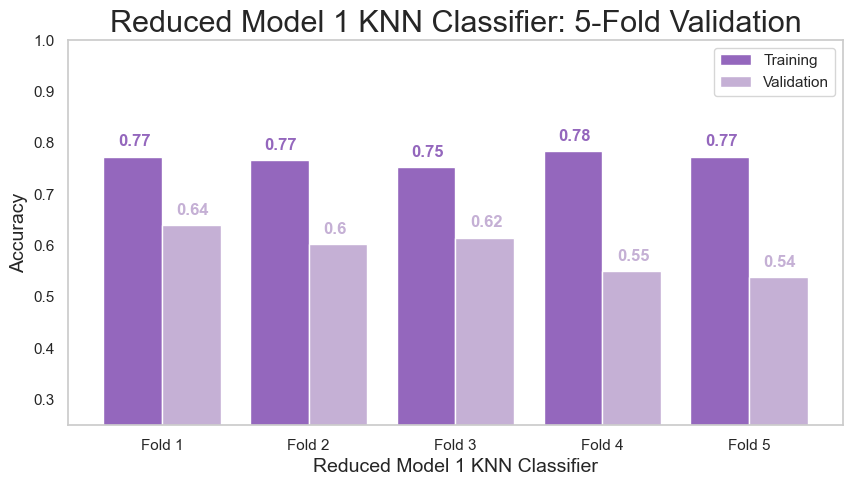

In [44]:
helper_functions.plot_k_fold_validation(neighbors.KNeighborsClassifier(), results_df, 'Reduced Model 1', 
                       'KNN Classifier', model_1_data[model_1_features], model_1_data[target_variable], 
                       palette=['#9467bd', '#c5b0d5'], folds=5)

Mean Training Accuracy score:  72.97
Mean Validation Accuracy score:  72.36


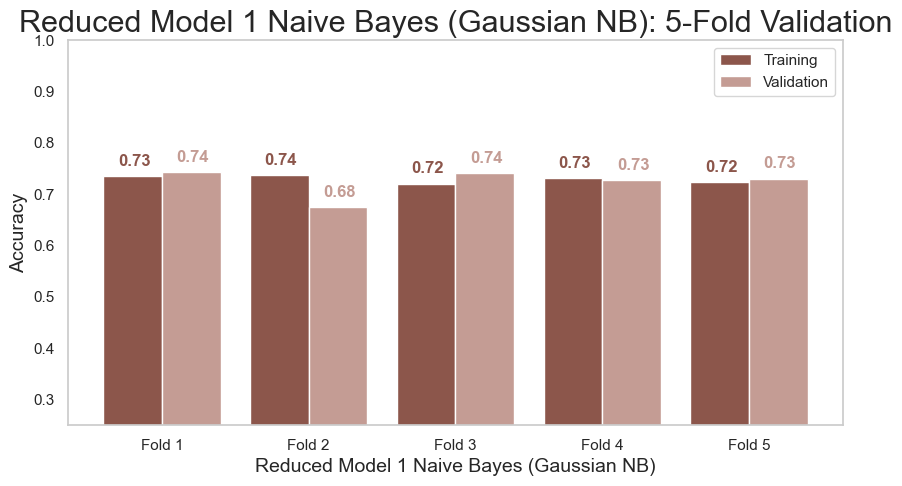

In [45]:
helper_functions.plot_k_fold_validation(naive_bayes.GaussianNB(), results_df, 'Reduced Model 1', 
                       'Naive Bayes (Gaussian NB)', model_1_data[model_1_features], model_1_data[target_variable], 
                       palette=['#8c564b', '#c49c94'], folds=5)

Mean Training Accuracy score:  70.42
Mean Validation Accuracy score:  67.35


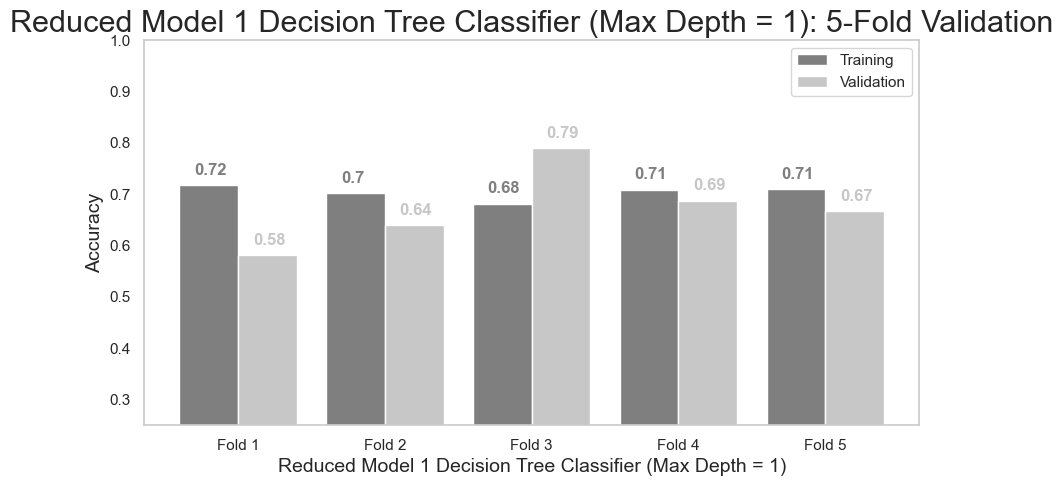

Mean Training Accuracy score:  70.42
Mean Validation Accuracy score:  67.35


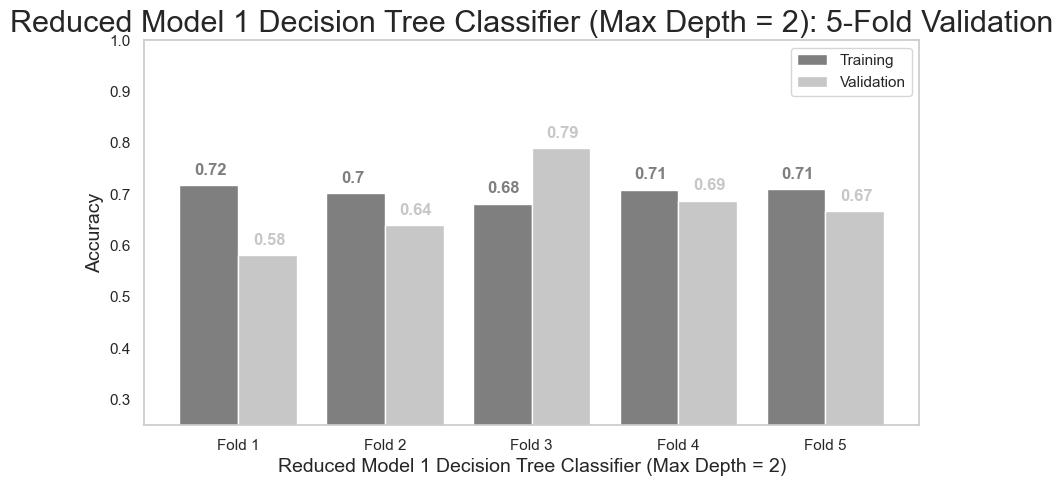

Mean Training Accuracy score:  72.75
Mean Validation Accuracy score:  71.36


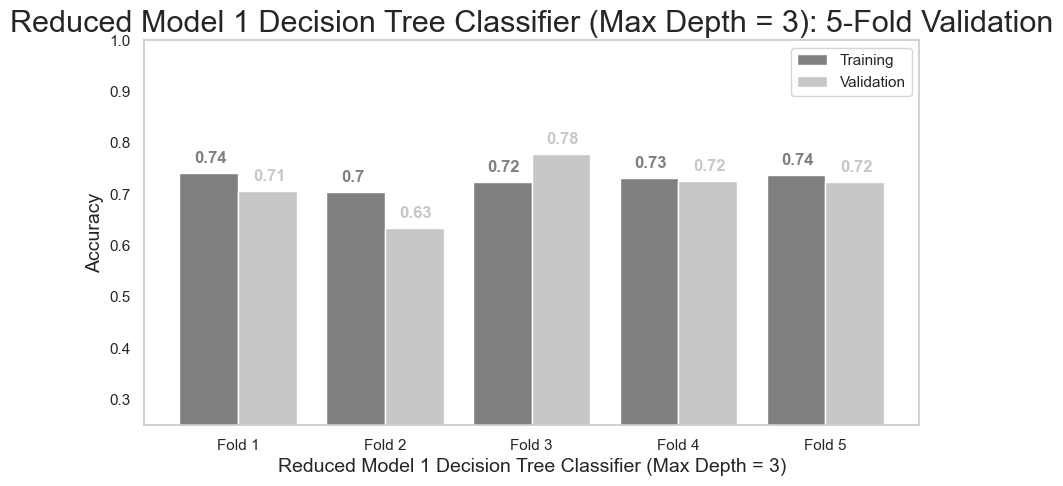

Mean Training Accuracy score:  78.42
Mean Validation Accuracy score:  68.92


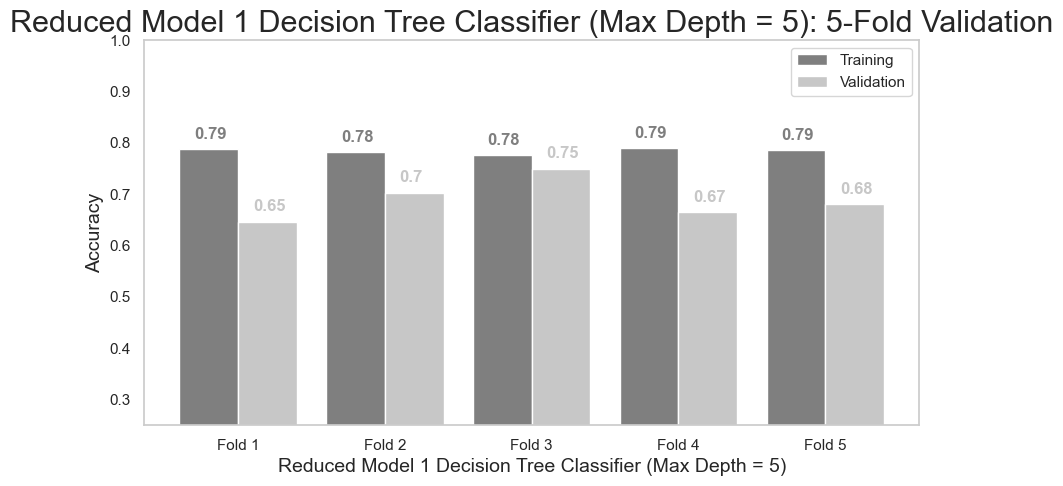

Mean Training Accuracy score:  92.64
Mean Validation Accuracy score:  64.1


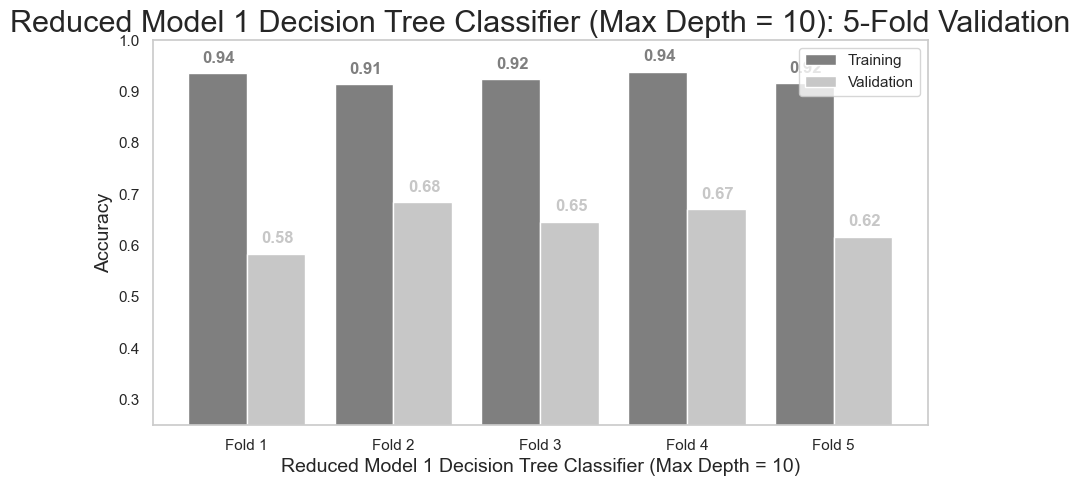

Mean Training Accuracy score:  100.0
Mean Validation Accuracy score:  65.1


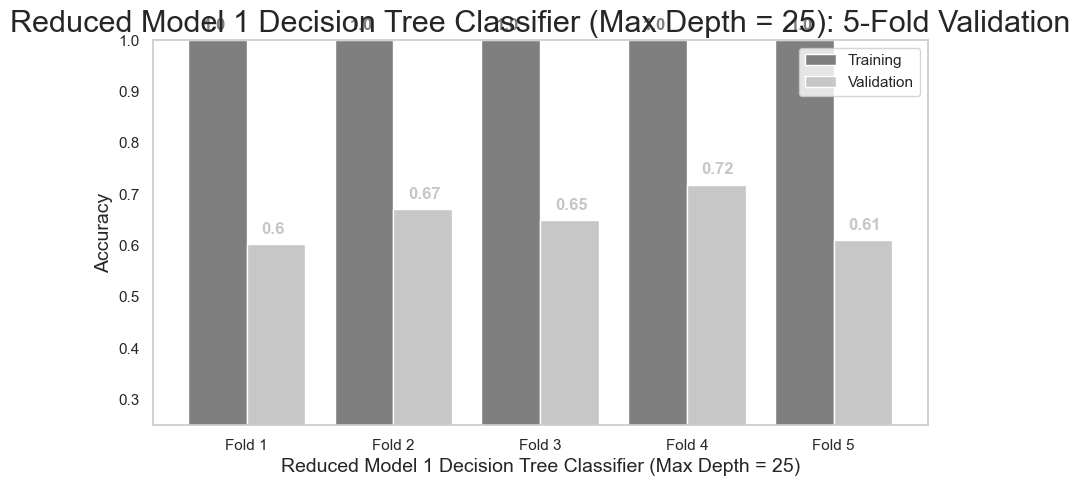

In [46]:
depths = [1, 2, 3, 5, 10, 25]
for depth in depths:
    model_type = 'Decision Tree Classifier (Max Depth = '+str(depth)+')'
    model_name = 'Reduced Model 1'
    helper_functions.plot_k_fold_validation(tree.DecisionTreeClassifier(criterion='log_loss', max_depth=depth), results_df, model_name, 
                           model_type, model_1_data[model_1_features], model_1_data[target_variable], 
                           palette=['#7f7f7f', '#c7c7c7'], folds=5)

In [47]:
results_df.drop_duplicates(inplace=True)
results_df.sort_values(by='Mean Validation Accuracy', ascending=False, inplace=True)
results_df.style.bar(cmap='Spectral').format(formatter={'Mean Training Accuracy': "{:.2f}%", 'Mean Validation Accuracy':"{:.2f}%"})\
        .hide_index()

Model Name,Model Type,Mean Training Accuracy,Mean Validation Accuracy
Logistic Regression,Reduced Model 1,74.81%,73.98%
Logistic Regression,Reduced Model 2,74.75%,73.92%
Ridge Classifier,Reduced Model 1,74.69%,73.73%
Logistic Regression,Reduced Model 3,74.72%,73.67%
Logistic Regression,Full Model,74.58%,72.80%
Naive Bayes (Gaussian NB),Reduced Model 1,72.97%,72.36%
Decision Tree Classifier (Max Depth = 3),Reduced Model 1,72.75%,71.36%
Decision Tree Classifier (Max Depth = 5),Reduced Model 1,78.42%,68.92%
Decision Tree Classifier (Max Depth = 1),Reduced Model 1,70.42%,67.35%
Decision Tree Classifier (Max Depth = 2),Reduced Model 1,70.42%,67.35%


## Conclusion

 - **Logistic Regression**
     - 1st best overall classification for this dataset and features.
 - **Ridge Classifier**
     - 2nd best overall. Extremely close to the accuracy of Logistic Regression. The differences between model and Logistic Regression are not statistically significant.
 - **SVM Classifier**
     - 4th best model type; overall inconsistent performance across 5 folds.
     - This is interesting because the original research paper that produced this dataset indicated success using a SVM model. However, this paper uses binary classification whereas the original research paper uses multiclass classification.
 - **KNN Classifier**
     - 6th best/worst overall out of all model types. This makes sense due when looking at the distribution plots of each independent variables and response variable. In most of the plots, both groups of good and bad quality wines had very similar distribution shapes. 
     - Due to how KNN classification works, the lack of difference between the groups severely impacted the accuracy of the model.
 - **Naive Bayes (Gaussian NB) Classifier**
     - 3rd best model. Some indication of high bias in the model, as is typical for this type. 
 - **Decision Tree Classifier**
     - 5th best/2nd worst overall model type. 
     - Most accurate with a max depth of 3; otherwise it is overfitted to the training set and has a lower validation accuracy score.

## Citations

1. D. C. Montgomery, E. A. Peck, and G. G. Vining, Introduction to Linear Regression Analysis, 5th ed. Chicester: Wiley, 2013. 

2. P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis, “Modeling wine preferences by data mining from physicochemical properties,” Decision Support Systems, vol. 47, no. 4. Elsevier BV, pp. 547–553, Nov. 2009. doi: 10.1016/j.dss.2009.05.016. Available https://archive.ics.uci.edu/ml/datasets/wine+quality

3. Zach, “The 6 Assumptions of Logistic Regression (with examples),” Statology, 13-Oct-2020. [Online]. Available: https://www.statology.org/assumptions-of-logistic-regression/.

4. H. Ilma, “Ridge and Lasso Regression,” Ridge and LASSO Regression, 18-Dec-2019. [Online]. Available: https://algotech.netlify.app/blog/ridge-lasso/ 